In [1]:
# imports
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
# import tensorflow_datasets as tfds
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import glob
import cv2
from PIL import Image

In [2]:
# check if all images are jpgs
# directories of the images
cat_img_path = "../../datasets/PetImages/Cat/"
dog_img_path = "../../datasets/PetImages/Dog/"

# get lists with the path of each image
cat_img_paths = glob.glob(cat_img_path + '*.jpg')
dog_img_paths = glob.glob(dog_img_path + '*.jpg')

test_img = Image.open(dog_img_paths[0])
print(test_img.format != 'JPEG')

for path in cat_img_paths:
    img = Image.open(path)
    if(img.format != 'JPEG'):
        img = img.convert('RGB')
        img.save(path, 'JPEG')

jpg_counter = 0
png_counter = 0
bmp_counter = 0
gif_counter = 0
psd_counter = 0

for path in cat_img_paths:
    data = open(path, 'rb').read(10)
    if(data[:3] == b'\xff\xd8\xff'):
        jpg_counter = jpg_counter+1
    elif(data[:8] == b'\x89\x50\x4e\x47\x0d\x0a\x1a\x0a'):
        png_counter = png_counter+1
    elif(data[:2] == b'\x42\x4d'):
        bmp_counter = bmp_counter+1
    elif(data[:6] in [b'\x47\x49\x46\x38\x37\x61', b'\x47\x49\x46\x38\x39\x61']):
        gif_counter = gif_counter+1
    elif(data[:4] == b'\x38\x42\x50\x53'):
        psd_counter = psd_counter+1
        
print(jpg_counter, 'of ', len(cat_img_paths), ' are jpg')
print(png_counter)
print(bmp_counter)
print(gif_counter)
print(psd_counter)
print(len(cat_img_paths) - jpg_counter - png_counter - bmp_counter - gif_counter - psd_counter, 'other')

#img666path = '../../datasets/PetImages/Cat/666.jpg'
#print(open(img666path, 'rb').read(10))
#img666 = cv2.imread(img666path)
#img666 = cv2.cvtColor(img666, cv2.COLOR_BGR2RGB)
#plt.imshow(img666)
#plt.show()

formats = {""}
for path in cat_img_paths:
    img = Image.open(path)
    formats.add(img.format)

print(formats)

False
12499 of  12499  are jpg
0
0
0
0
0 other
{'', 'JPEG'}


In [3]:
# deleted 666.jpg from cat images, apparently it was empty and caused errors
# deleted 11702.jpg from dog images for the same reason
# -,,- 1259.jpg
# directories of the images
cat_img_path = "../../datasets/PetImages/Cat/"
dog_img_path = "../../datasets/PetImages/Dog/"

# get lists with the path of each image
cat_img_paths = glob.glob(cat_img_path + '*.jpg')
dog_img_paths = glob.glob(dog_img_path + '*.jpg')

# make a pandas dataframe
data = {
    "emptystring": "emptyclass"
}

img_paths = cat_img_paths + dog_img_paths
dataframe = pd.DataFrame(img_paths)
dataframe.rename({0:'path'}, axis = 1, inplace = True)

for i in cat_img_paths:
    data[i] = 'cat'

for i in dog_img_paths:
    data[i] = 'dog'

print(data[cat_img_paths[0]])
data.pop("emptystring")
dataframe['classname'] = dataframe['path'].map(data)

classnames = dataframe['classname'].unique()
K = classnames.size
name2class = dict(zip(classnames, range(K)))
dataframe['class'] = dataframe['classname'].map(name2class)

print(dataframe.head())
print(dataframe.shape)
print(dataframe.loc[12500, :])
print(dataframe.sample(n=5))

cat
                                     path classname  class
0  ../../datasets/PetImages/Cat/10571.jpg       cat      0
1   ../../datasets/PetImages/Cat/5960.jpg       cat      0
2   ../../datasets/PetImages/Cat/9172.jpg       cat      0
3   ../../datasets/PetImages/Cat/2151.jpg       cat      0
4    ../../datasets/PetImages/Cat/389.jpg       cat      0
(24997, 3)
path         ../../datasets/PetImages/Dog/5960.jpg
classname                                      dog
class                                            1
Name: 12500, dtype: object
                                         path classname  class
19727  ../../datasets/PetImages/Dog/11564.jpg       dog      1
20482   ../../datasets/PetImages/Dog/4182.jpg       dog      1
1583     ../../datasets/PetImages/Cat/637.jpg       cat      0
3490    ../../datasets/PetImages/Cat/3364.jpg       cat      0
3468   ../../datasets/PetImages/Cat/11421.jpg       cat      0


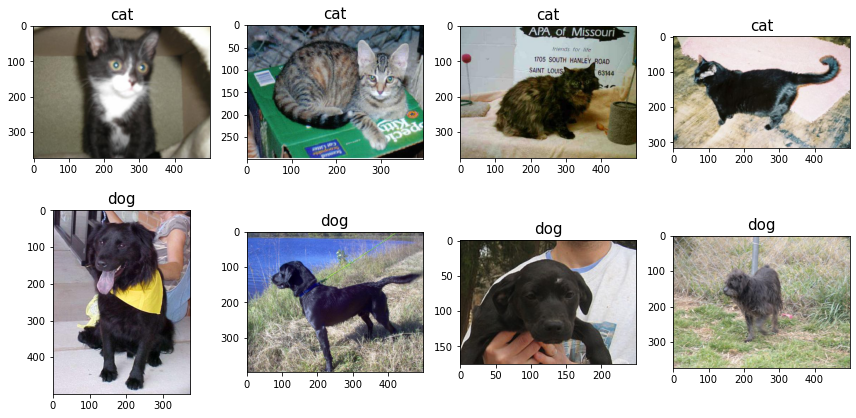

In [4]:
# plot examples
examples_per_class = 4
_, ax = plt.subplots(nrows = 2, ncols = examples_per_class,
                    figsize = (3*examples_per_class, 3*2))
for i in range(2):
    sample = dataframe[dataframe['class'] == i].sample(n=examples_per_class)
    for j in range(examples_per_class):
        path = sample.iloc[j][0]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(img)
        ax[i,j].set_title(classnames[i], fontsize = 15)
plt.tight_layout()
plt.show()

In [5]:
# 500 test images
# 500 validation images
# 23997 training images
num_images = dataframe.shape[0]
num_test = 500
num_val = 500
num_train = num_images - num_val - num_test

all_idxs = np.array(range(num_images))
np.random.shuffle(all_idxs)

test_df = dataframe.iloc[all_idxs[0:num_test]]
val_df = dataframe.iloc[all_idxs[num_test:num_test+num_val]]
train_df = dataframe.iloc[all_idxs[num_test+num_val:]]
print(test_df.shape[0], " ", val_df.shape[0], " ", train_df.shape[0])

500   500   23997


In [6]:
img_size = 128
batch_size = 32

In [7]:
def path_to_array(filename, label):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.cast(img, dtype = tf.float32)/255
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.image.random_flip_left_right(img)
    #num_rot = np.random.randint(0,4)
    img = tf.image.random_brightness(img, max_delta = 0.1)
    img = tf.image.random_hue(img, max_delta = 0.02)
    img = tf.image.random_saturation(img, lower = 0.95, upper = 1.05)
    label = tf.one_hot(label, depth = 2)
    return img, label

def make_dataset(df):
    ds_path = tf.data.Dataset.from_tensor_slices((df['path'],df['class']))
    ds = ds_path.map(path_to_array)
    ds = ds.batch(batch_size)
    return ds

test_ds = make_dataset(test_df)
val_ds = make_dataset(val_df)
train_ds = make_dataset(train_df)
train_ds = train_ds.repeat()
print(train_ds.cardinality)
#for image_batch in train_ds:
#    print(image_batch[0])
#    break

<bound method DatasetV2.cardinality of <RepeatDataset shapes: ((None, 128, 128, 3), (None, 2)), types: (tf.float32, tf.float32)>>
tf.Tensor(
[[[[0.31141952 0.46685305 0.29418397]
   [0.48898628 0.6444199  0.47175077]
   [0.4042238  0.55965745 0.38698828]
   ...
   [0.34786665 0.43448287 0.30611292]
   [0.4355923  0.4729556  0.40182236]
   [0.46701685 0.53380823 0.42941126]]

  [[0.4213261  0.59486675 0.4013843 ]
   [0.38247234 0.556013   0.36253053]
   [0.42554232 0.599083   0.40560052]
   ...
   [0.38096407 0.48112684 0.32524413]
   [0.39866418 0.50603116 0.37937468]
   [0.31532946 0.45522022 0.29334617]]

  [[0.37271455 0.5666348  0.35120714]
   [0.33874115 0.53266144 0.31723374]
   [0.3735791  0.56749934 0.3520717 ]
   ...
   [0.3040257  0.44314268 0.24887572]
   [0.3219937  0.50676024 0.30708683]
   [0.26236084 0.47774076 0.24565259]]

  ...

  [[0.44278765 0.5635177  0.46061984]
   [0.32148832 0.4400804  0.34531596]
   [0.37305257 0.48655137 0.38250244]
   ...
   [0.4012266  0.545

In [8]:
# model: https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb?scriptVersionId=7784920
kernel_size = (3, 3)
pool_size   = (2, 2)
first_filters  = 32
second_filters = 64
third_filters  = 128
dropout_conv  = 0.3
dropout_dense = 0.3

def make_cnn_model():
    cnn_model = tf.keras.models.Sequential() # sequential stack of layers

    cnn_model.add( BatchNormalization(input_shape = (img_size, img_size, 3)))
    cnn_model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
    cnn_model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
    cnn_model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
    cnn_model.add( MaxPooling2D (pool_size = pool_size)) 
    cnn_model.add( Dropout (dropout_conv))

    cnn_model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
    cnn_model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
    cnn_model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
    cnn_model.add( MaxPooling2D (pool_size = pool_size))
    cnn_model.add( Dropout (dropout_conv))

    cnn_model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
    cnn_model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
    cnn_model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
    cnn_model.add( MaxPooling2D (pool_size = pool_size))
    cnn_model.add( Dropout (dropout_conv))

    cnn_model.add( Flatten())
    cnn_model.add( Dense (256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.005)))
    cnn_model.add( Dropout (dropout_dense))
    cnn_model.add( Dense (2, activation = "softmax"))
    return cnn_model

In [9]:
if(os.path.exists('cats_vs_dogs_cnn_model')):
    cnn_model = tf.keras.models.load_model('cats_vs_dogs_cnn_model')
    cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = 'binary_crossentropy', metrics = ['accuracy'])
    # binary_crossentropy or categorical_crossentropy
else:
    cnn_model = make_cnn_model()
    cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = 'binary_crossentropy', metrics = ['accuracy'])
    # binary_crossentropy or categorical_crossentropy
    modelfname = 'cats_vs_dogs_cnn.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        modelfname, monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 0)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', mode = 'min', factor = 0.75, patience = 4, verbose = 0)
    history = cnn_model.fit(
        train_ds, epochs = 50, 
        steps_per_epoch = 600,
        validation_data = val_ds, verbose = 1,
        callbacks = [checkpoint, reduce_lr])
    cnn_model.save('cats_vs_dogs_cnn_model')
    # plot the training history as loss and accuracy curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    _, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].plot(epochs, val_loss, 'g', label = 'Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].legend()
    ax[1].plot(epochs, acc, 'bo', label = 'Training acc')
    ax[1].plot(epochs, val_acc, 'g', label = 'Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].legend();

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(8*8*256, use_bias = False, input_shape = (100, )))
    model.add(Reshape((8,8,256)))
    assert model.output_shape == (None,8,8,256)
    model.add(Conv2DTranspose(256, (4, 4), strides = (1, 1), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(256, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(32, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(3, (3, 3), strides = (1, 1), padding = 'same', use_bias = False, activation = 'tanh'))
    return model

In [11]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1048576   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       1048576   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(3, (4, 4), strides = (2, 2), padding = 'same', use_bias = False, input_shape = [128, 128, 3]))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(48, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(96, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(192, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(384, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 3)         144       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 48)        2304      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        73728     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 96)       

In [14]:
lr = 1e-4
beta1 = 0.5

# define loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = beta1, beta_2 = 0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = beta1, beta_2 = 0.999)

In [15]:
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_imgs = generator(noise, training = True)
        fake_output = discriminator(fake_imgs, training = True)
        real_output = discriminator(images, training = True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))
    
def train(dataset, epochs, verbose = 0):
    for epoch in range(epochs):
        start = time.time()
        img_batch_counter = 0
        for image_batch in dataset:
            train_step(image_batch[0])
            img_batch_counter = img_batch_counter+1
            if(img_batch_counter >= 749):
                break
        if(verbose == 1):
            print("time for epoch ", epoch+1, " is ", time.time()-start)
    

In [16]:
print(train_ds.cardinality)

<bound method DatasetV2.cardinality of <RepeatDataset shapes: ((None, 128, 128, 3), (None, 2)), types: (tf.float32, tf.float32)>>


In [17]:
gen_path = 'cats_vs_dogs_gen'
disc_path = 'cats_vs_dogs_disc'
print("batches in train_ds: ", 23997 / 32)

if(os.path.exists(gen_path) and os.path.exists(disc_path)):
    generator = tf.keras.models.load_model(gen_path)
    discriminator = tf.keras.models.load_model(disc_path)
else:
    start_time = time.time()
    train(train_ds, epochs = 500, verbose = 0)
    print("training for 500 epochs done in ", time.time()-start_time, " sec")
    generator.save(gen_path)
    discriminator.save(disc_path)

batches in train_ds:  749.90625


In [18]:
# train more if necessary
"""
additional_epochs = 200
train(train_ds, epochs = additional_epochs, verbose = 0)
# trained for a total of 700 epochs
generator.save(gen_path)
discriminator.save(disc_path)
#"""

'\nadditional_epochs = 200\ntrain(train_ds, epochs = additional_epochs, verbose = 0)\n# trained for a total of 700 epochs\ngenerator.save(gen_path)\ndiscriminator.save(disc_path)\n#'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[0.9287609]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.3300544]], shape=(1, 1), dtype=float32)


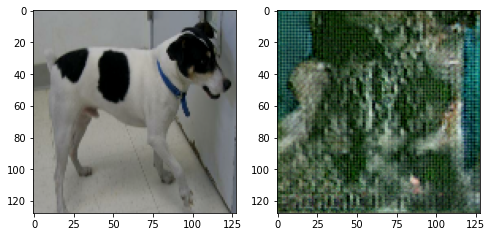

In [21]:
test_img = test_ds.as_numpy_iterator().next()[0][0]
noise = tf.random.normal([1,100])
fake_img = generator(noise)
_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(test_img)
ax[1].imshow(fake_img[0][:][:][:])
test_img = np.expand_dims(test_img, 0)
print(discriminator(test_img))
print(discriminator(fake_img))

# xai algorithm

[3.4408043e-07 9.9999964e-01]


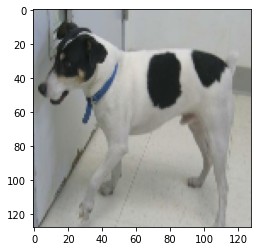

In [59]:
# element to be changed
x_ = np.expand_dims(test_ds.as_numpy_iterator().next()[0][0], 0)
x_tfVar = tf.Variable(x_)
# classifier output
print(cnn_model(x_tfVar).numpy().squeeze())
plt.imshow(x_[0])

In [60]:
#target function
@tf.function
def g(x, index):
    res = tf.math.log(discriminator(x)) - tf.math.log(tf.squeeze(cnn_model(x_tfVar))[index])
    return res

index = tf.argmax(tf.squeeze(cnn_model(x_tfVar))).numpy()
print(g(x_tfVar, index))

tf.Tensor([[-0.26802948]], shape=(1, 1), dtype=float32)


In [61]:
max_iter = 600
max_change = 0.005     # maximum change per iteration and pixel
min_alpha = 100000     # a high value may be necessary to escape a local maximum
close_enough = False
epsilon = 1e-16
iter = 0

index = tf.argmax(tf.squeeze(cnn_model(x_tfVar))).numpy()

while not close_enough and iter < max_iter:
    # derive discriminator and classifier
    with tf.GradientTape() as tape:
        g_val = g(x_tfVar, index)
    grad = tape.gradient(g_val, x_tfVar)
    
    max_grad = tf.abs(tf.reduce_max(grad))
    alpha = tf.minimum(min_alpha, max_change/tf.maximum(max_grad, epsilon))
    
    if(iter % 10 == 0):
        #print("grad_p/p: ", grad_p/p, " grad_f/f: ", grad_f/tf.reduce_max(f))
        pass
    
    x_tfVar.assign(x_tfVar + alpha * grad)
    x_tfVar.assign(tf.clip_by_value(x_tfVar, clip_value_min = 0, clip_value_max = 1))
    iter += 1
    new_index = tf.argmax(tf.squeeze(cnn_model(x_tfVar))).numpy()
    if ((new_index != index) and (discriminator(x_tfVar).numpy() > 0)): # done when the prediction has changed
        close_enough = True
        print("done after ", iter, " steps")

done after  11  steps


tf.Tensor([[0.9999999]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6356445  0.36435553]], shape=(1, 2), dtype=float32)


Text(0.5, 1.0, 'after xai alg')

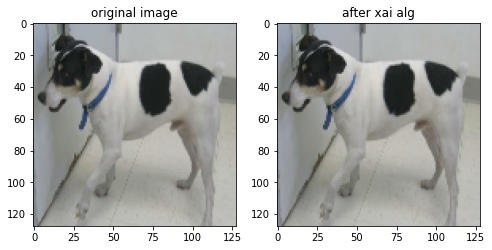

In [62]:
print(discriminator(x_tfVar))
print(cnn_model(x_tfVar))
_, ax = plt.subplots(1,2,figsize = (8,4))
ax[0].imshow(x_[0])
ax[0].set_title("original image")
ax[1].imshow(x_tfVar[0])
ax[1].set_title("after xai alg")